# Collocation

<a target="_blank" href="https://colab.research.google.com/github/arthurrichards77/smply/blob/master/collocation.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

The collocation approach solves nonlinear trajectory optimization essentially by curve-fitting.  The decision variables are a the states and controls at a set of _collocation points_.  These are enough to determine polynomials that interpolate the collocation points, so the derivative values of these quantities are also known.  An analytical model of the dynamics is used to enforce the differential constraints~$\dot{x}(t) = f(x(t),u(t))$ at the collocation points.  This ensures the solution satisfies, approximately, the differential equation of the dynamics, without the overhead of numerical integration (see Shooting Method).

In [381]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [382]:
s0 = (0,0,0.5*np.pi)
sf = (0.7,0.7,-0.5*np.pi)

In [383]:
colloc_dist = np.array([0,0.15,0.35,0.65,0.85,1.0])
colloc_dist = np.array([0,0.25,0.75,1.0])
num_colloc = len(colloc_dist)

In [384]:
coeffs_to_colloc = np.array([colloc_dist**i for i in range(num_colloc)]).T
coeffs_to_colloc

array([[1.      , 0.      , 0.      , 0.      ],
       [1.      , 0.25    , 0.0625  , 0.015625],
       [1.      , 0.75    , 0.5625  , 0.421875],
       [1.      , 1.      , 1.      , 1.      ]])

In [385]:
coeffs_to_colloc_deriv = np.vstack((colloc_dist*0,  np.array([i*colloc_dist**(i-1) for i in range(1,num_colloc)]))).T
coeffs_to_colloc_deriv

array([[0.    , 1.    , 0.    , 0.    ],
       [0.    , 1.    , 0.5   , 0.1875],
       [0.    , 1.    , 1.5   , 1.6875],
       [0.    , 1.    , 2.    , 3.    ]])

In [386]:
colloc_to_colloc_deriv = coeffs_to_colloc_deriv@np.linalg.inv(coeffs_to_colloc)
colloc_to_colloc_deriv

array([[-6.33333333,  8.        , -2.66666667,  1.        ],
       [-2.        ,  0.66666667,  2.        , -0.66666667],
       [ 0.66666667, -2.        , -0.66666667,  2.        ],
       [-1.        ,  2.66666667, -8.        ,  6.33333333]])

In [387]:
z = np.hstack((np.linspace(s0[0],sf[0],num_colloc),
               np.linspace(s0[1],sf[1],num_colloc),
               np.linspace(s0[2],sf[2],num_colloc),
               np.ones_like(colloc_dist)*1.8,
               np.zeros_like(colloc_dist),
               5.0))
z

array([ 0.        ,  0.23333333,  0.46666667,  0.7       ,  0.        ,
        0.23333333,  0.46666667,  0.7       ,  1.57079633,  0.52359878,
       -0.52359878, -1.57079633,  1.8       ,  1.8       ,  1.8       ,
        1.8       ,  0.        ,  0.        ,  0.        ,  0.        ,
        5.        ])

In [388]:
def extract_components(z):
    x = z[0:num_colloc]
    y = z[num_colloc:(2*num_colloc)]
    h = z[(2*num_colloc):(3*num_colloc)]
    v = z[(3*num_colloc):(4*num_colloc)]
    k = z[(4*num_colloc):(5*num_colloc)]
    T = z[(5*num_colloc)]
    return x,y,h,v,k,T

In [389]:
def dynamics_constraints(z):
    x,y,h,v,k,T = extract_components(z)
    xdot_err = (1/T)*colloc_to_colloc_deriv@x - v*np.sin(h) # x-dot = v sin h
    ydot_err = (1/T)*colloc_to_colloc_deriv@y - v*np.cos(h) # y-dot = v cos h
    hdot_err = (1/T)*colloc_to_colloc_deriv@h - v*k # h-dot = v k
    return np.hstack((xdot_err,ydot_err,hdot_err))

dynamics_constraints(z)

array([-1.53555556, -0.77555556,  1.02444444,  2.06444444,  0.26444444,
       -1.43440128, -1.43440128,  0.26444444, -1.18682389, -0.55850536,
       -0.55850536, -1.18682389])

In [390]:
test_v = 0.5
test_h = np.pi/12
test_T = 16.0

test_x = test_v*test_T*np.sin(test_h)*colloc_dist
test_y = test_v*test_T*np.cos(test_h)*colloc_dist

dyn_test_z = np.hstack((test_x,
                        test_y,
                        np.ones_like(colloc_dist)*test_h,
                        np.ones_like(colloc_dist)*test_v,
                        np.zeros_like(colloc_dist),
                        test_T))

dynamics_constraints(dyn_test_z)

array([ 0.00000000e+00,  0.00000000e+00, -1.11022302e-16,  2.22044605e-16,
        5.55111512e-17,  5.55111512e-17, -3.88578059e-16,  6.10622664e-16,
        0.00000000e+00, -8.67361738e-18, -2.60208521e-17,  1.11022302e-16])

In [391]:
def boundary_constraints(z):
    init_err = np.array([s0[i] - z[i*num_colloc] for i in range(len(s0))])
    term_err = np.array([sf[i] - z[num_colloc + i*num_colloc - 1] for i in range(len(sf))])
    return np.hstack((init_err,term_err))

boundary_constraints(z)

array([0., 0., 0., 0., 0., 0.])

In [392]:
bc_test_z = np.hstack((np.linspace(s0[0],sf[0],num_colloc),
                    np.linspace(s0[1],sf[1],num_colloc),
                    np.linspace(s0[2],sf[2],num_colloc),
                    np.ones_like(colloc_dist),
                    np.zeros_like(colloc_dist),
                    5.0))

boundary_constraints(bc_test_z)

array([0., 0., 0., 0., 0., 0.])

In [393]:
vmax = 1.0
vmin = 0.1
kmax = 6.0

bounds = [(-1,1)]*2*num_colloc + [(-2*np.pi,2*np.pi)]*num_colloc + [(vmin,vmax)]*num_colloc + [(-kmax,kmax)]*num_colloc + [(0.001,100.0)]
bounds

[(-1, 1),
 (-1, 1),
 (-1, 1),
 (-1, 1),
 (-1, 1),
 (-1, 1),
 (-1, 1),
 (-1, 1),
 (-6.283185307179586, 6.283185307179586),
 (-6.283185307179586, 6.283185307179586),
 (-6.283185307179586, 6.283185307179586),
 (-6.283185307179586, 6.283185307179586),
 (0.1, 1.0),
 (0.1, 1.0),
 (0.1, 1.0),
 (0.1, 1.0),
 (-6.0, 6.0),
 (-6.0, 6.0),
 (-6.0, 6.0),
 (-6.0, 6.0),
 (0.001, 100.0)]

In [394]:
def all_eq_constraints(z):
    return np.hstack((dynamics_constraints(z),boundary_constraints(z)))

all_eq_constraints(z)

array([-1.53555556, -0.77555556,  1.02444444,  2.06444444,  0.26444444,
       -1.43440128, -1.43440128,  0.26444444, -1.18682389, -0.55850536,
       -0.55850536, -1.18682389,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ])

In [395]:
constraints = [{'type':'eq','fun':all_eq_constraints}]

In [396]:
def cost(z):
    return(z[-1])

In [397]:
res = minimize(cost,bc_test_z,method='SLSQP',bounds=bounds,constraints=constraints,options={'maxiter':1000})
res

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 1.6989067191811047
       x: [-9.862e-23  3.292e-01 ... -6.000e+00  1.699e+00]
     nit: 19
     jac: [ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]
    nfev: 424
    njev: 19

In [398]:
x,y,h,v,k,T = extract_components(res.x)

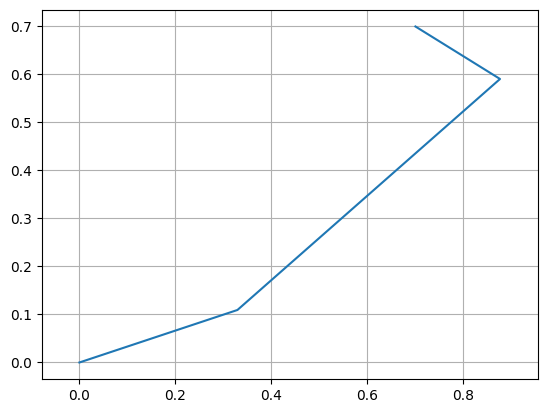

In [399]:
plt.plot(x,y)
plt.axis('equal')
plt.grid('on')
plt.show()

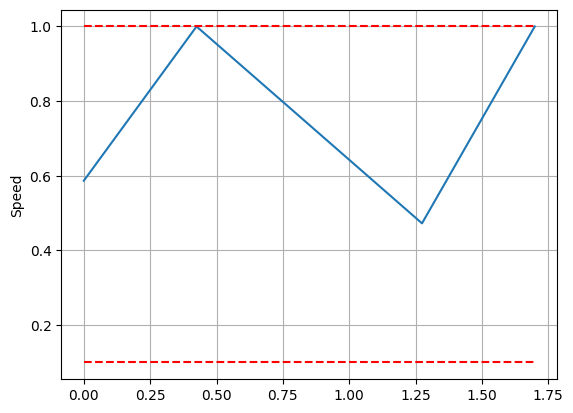

In [400]:
plt.plot(T*colloc_dist, v)
plt.plot([0,T], [vmax,vmax],'r--')
plt.plot([0,T], [vmin,vmin],'r--')
plt.grid('on')
plt.ylabel('Speed')
plt.show()

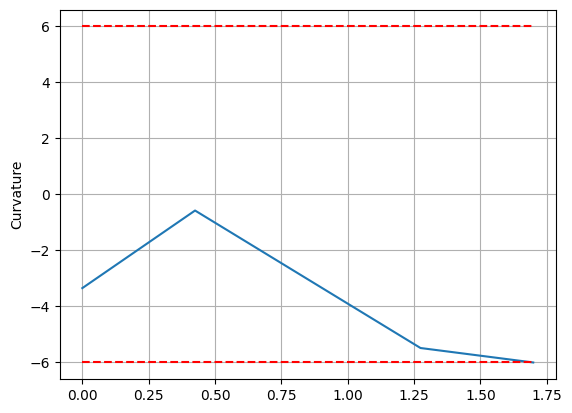

In [401]:
plt.plot(T*colloc_dist,k)
plt.plot([0,T], [kmax,kmax],'r--')
plt.plot([0,T], [-kmax,-kmax],'r--')
plt.grid('on')
plt.ylabel('Curvature')
plt.show()

In [402]:
eval_dist = np.linspace(0,1,100)

In [403]:
coeffs_to_eval = np.array([eval_dist**i for i in range(len(colloc_dist))]).T
coeffs_to_eval

array([[1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 1.01010101e-02, 1.02030405e-04, 1.03061015e-06],
       [1.00000000e+00, 2.02020202e-02, 4.08121620e-04, 8.24488122e-06],
       [1.00000000e+00, 3.03030303e-02, 9.18273646e-04, 2.78264741e-05],
       [1.00000000e+00, 4.04040404e-02, 1.63248648e-03, 6.59590497e-05],
       [1.00000000e+00, 5.05050505e-02, 2.55076013e-03, 1.28826269e-04],
       [1.00000000e+00, 6.06060606e-02, 3.67309458e-03, 2.22611793e-04],
       [1.00000000e+00, 7.07070707e-02, 4.99948985e-03, 3.53499282e-04],
       [1.00000000e+00, 8.08080808e-02, 6.52994592e-03, 5.27672398e-04],
       [1.00000000e+00, 9.09090909e-02, 8.26446281e-03, 7.51314801e-04],
       [1.00000000e+00, 1.01010101e-01, 1.02030405e-02, 1.03061015e-03],
       [1.00000000e+00, 1.11111111e-01, 1.23456790e-02, 1.37174211e-03],
       [1.00000000e+00, 1.21212121e-01, 1.46923783e-02, 1.78089434e-03],
       [1.00000000e+00, 1.31313131e-01, 1.72431385e

In [404]:
colloc_to_eval = coeffs_to_eval@np.linalg.inv(coeffs_to_colloc)

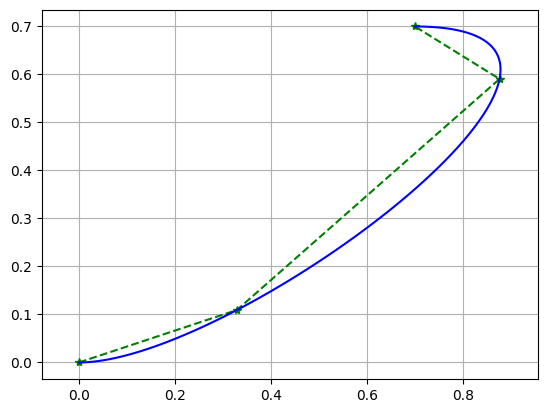

In [405]:
plt.plot(x,y,'*g--')
plt.plot(colloc_to_eval@x,
         colloc_to_eval@y,'b-')
plt.axis('equal')
plt.grid('on')
plt.show()

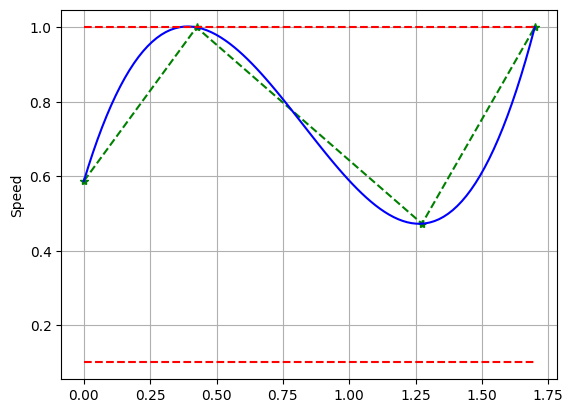

In [406]:
plt.plot(T*colloc_dist, v, '*g--')
plt.plot(T*eval_dist, colloc_to_eval@v, 'b-')
plt.plot([0,T], [vmax,vmax],'r--')
plt.plot([0,T], [vmin,vmin],'r--')
plt.grid('on')
plt.ylabel('Speed')
plt.show()

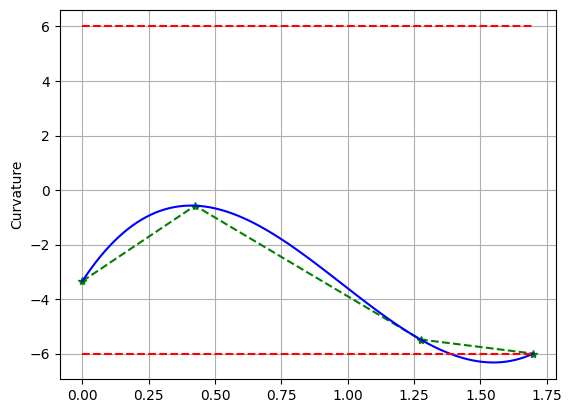

In [407]:
plt.plot(T*colloc_dist,k,'*g--')
plt.plot(T*eval_dist, colloc_to_eval@k, 'b-')
plt.plot([0,T], [kmax,kmax],'r--')
plt.plot([0,T], [-kmax,-kmax],'r--')
plt.grid('on')
plt.ylabel('Curvature')
plt.show()